## Libraries

In [1]:
# This is our custom implementation of the KNN algorithm, the algorithm is in the path knn/knn_implementation.py
from knn_implementation import KNN
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
    )
import time

import numpy as np
import pandas as pd

## Usage example

In [3]:
# Basic training and test data
X_train = np.array([[1, 2], [2, 3], [3, 4], [4, 5], [5, 6]])
y_train = np.array([0, 1, 0, 1, 0])

X_test = np.array([[4, 6], [3, 4], [4, 5]])

# Initialize the KNN algorithm
# Parameters:
# k: Number of neighbors to consider (default=3)
# distance: Distance metric to use (default='euclidean'), options: 'euclidean', 'manhattan', 'cosine' 
# weighted: Assign weights to the neighbors based on their distance (default=False)
knn = KNN(k=6, distance='cosine', weighted=True)

# Function to "train" the algorithm, in this case it just stores the training data
knn.fit(X_train, y_train)

# Function to predict the class of the test data
prediction = knn.predict(X_test)

prediction

[0.990613562781246, 0.02564608169651176, 0.936341882823386]

## Dataset 1 - Bike Sharing

### Data preprocessing


In [2]:
# Load the bike sharing dataset
from sklearn.preprocessing import OneHotEncoder

bike_sharing = pd.read_csv('../datasets/original/bike_sharing.csv')

bike_sharing = bike_sharing.drop(['casual', 'registered'], axis=1)

encoderOHE = OneHotEncoder()

# one-hot encoding for the categorical variables season, weathersit
season_encoded = encoderOHE.fit_transform(bike_sharing[['season']]).toarray()
weathersit_encoded = encoderOHE.fit_transform(bike_sharing[['weathersit']]).toarray()

# Add the encoded columns to the dataset
bike_sharing['spring'] = season_encoded[:, 0]
bike_sharing['summer'] = season_encoded[:, 1]
bike_sharing['fall'] = season_encoded[:, 2]
bike_sharing['winter'] = season_encoded[:, 3]

bike_sharing['weather_1'] = weathersit_encoded[:, 0]
bike_sharing['weather_2'] = weathersit_encoded[:, 1]
bike_sharing['weather_3'] = weathersit_encoded[:, 2]
bike_sharing['weather_4'] = weathersit_encoded[:, 3]

# Drop the original columns
bike_sharing = bike_sharing.drop(['season', 'weathersit'], axis=1)

# Drop columns that are not needed
bike_sharing = bike_sharing.drop(['instant', 'dteday'], axis=1)

### Splitting the data and normalizing it

In [3]:
# Split the dataset into features and target variable
X = bike_sharing.drop('cnt', axis=1)
y = bike_sharing['cnt']

# Split the dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Normalize the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Note: In a previous test I normalized the columns 'casual', 'registered' and the results were way worse. With mae around 30 and mse around 1700
# With the current configuration we are getting good results, mae around ~1 and mse around ~5-30
variables_to_normalize = ['mnth', 'hr', 'weekday']

X_train[variables_to_normalize] = scaler.fit_transform(X_train[variables_to_normalize]) 
X_test[variables_to_normalize] = scaler.transform(X_test[variables_to_normalize])

X_train
 

,yr,mnth,hr,holiday,weekday,workingday,temp,atemp,hum,windspeed,spring,summer,fall,winter,weather_1,weather_2,weather_3,weather_4
1945,0,0.181818,0.869565,0,1.000000,0,0.28,0.2727,0.45,0.2537,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
13426,1,0.545455,0.652174,0,0.500000,1,0.92,0.8485,0.35,0.3582,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
12898,1,0.454545,0.652174,0,0.333333,1,0.72,0.6515,0.28,0.4627,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2570,0,0.272727,0.000000,0,0.833333,1,0.36,0.3485,0.62,0.1940,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
10764,1,0.181818,0.652174,0,0.666667,1,0.52,0.5000,0.39,0.3582,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,1,0.272727,0.391304,0,0.833333,1,0.46,0.4545,0.88,0.0896,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
11964,1,0.363636,0.739130,0,0.833333,1,0.66,0.6212,0.34,0.1343,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
5390,0,0.636364,0.521739,0,0.500000,1,0.80,0.7273,0.43,0.2836,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
860,0,0.090909,0.304348,0,0.333333,1,0.24,0.1970,0.65,0.4179,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Testing multiple configurations

In [9]:
def predict_knn_all_configurations(X_train, y_train, X_test, y_test, min_k=5, max_k=5):
    results = []
    for k in range(min_k, max_k+1):
        for distance in ['euclidean', 'manhattan', 'cosine']:
            for weighted in [True, False]:
                knn = KNN(k=k, distance=distance, weighted=weighted)
                knn.fit(X_train, y_train)
                prediction = knn.predict(X_test)
                mae = mean_absolute_error(y_test, prediction)
                mse = mean_squared_error(y_test, prediction)
                r2 = r2_score(y_test, prediction)
                results.append({
                    'k': k,
                    'distance': distance,
                    'weighted': weighted,
                    'mae': mae,
                    'mse': mse,
                    'r2': r2
                })
    return results

In [10]:
results = predict_knn_all_configurations(X_train, y_train, X_test, y_test, 6, 8)

results

[{'k': 6,
  'distance': 'euclidean',
  'weighted': True,
  'mae': 60.47833804290666,
  'mse': 8656.549403476201,
  'r2': 0.7308145553383512},
 {'k': 6,
  'distance': 'euclidean',
  'weighted': False,
  'mae': 64.4572305331799,
  'mse': 9490.363060989643,
  'r2': 0.704886152495461},
 {'k': 6,
  'distance': 'manhattan',
  'weighted': True,
  'mae': 62.366232837628125,
  'mse': 9233.47631514394,
  'r2': 0.7128743438272624},
 {'k': 6,
  'distance': 'manhattan',
  'weighted': False,
  'mae': 67.14652857690832,
  'mse': 10328.750888633167,
  'r2': 0.6788155105266751},
 {'k': 6,
  'distance': 'cosine',
  'weighted': True,
  'mae': 59.0298020679774,
  'mse': 8579.296468631106,
  'r2': 0.7332168249550814},
 {'k': 6,
  'distance': 'cosine',
  'weighted': False,
  'mae': 64.56547756041427,
  'mse': 9566.756476153945,
  'r2': 0.7025106106401847},
 {'k': 7,
  'distance': 'euclidean',
  'weighted': True,
  'mae': 61.19589033191048,
  'mse': 8710.975530972953,
  'r2': 0.7291221117735353},
 {'k': 7,
 

In [31]:
knn = KNN(k=6, distance='euclidean', weighted=True)

knn.fit(X_train, y_train)

runtime_start = time.process_time()
prediction = knn.predict(X_test)
runtime_end = time.process_time()
mae = mean_absolute_error(y_test, prediction)
mse = mean_squared_error(y_test, prediction)
r2 = r2_score(y_test, prediction)


runtime = runtime_end - runtime_start

mae, mse, r2, runtime

(60.47833804290666, 8656.549403476201, 0.7308145553383512, 19.428946999999994)

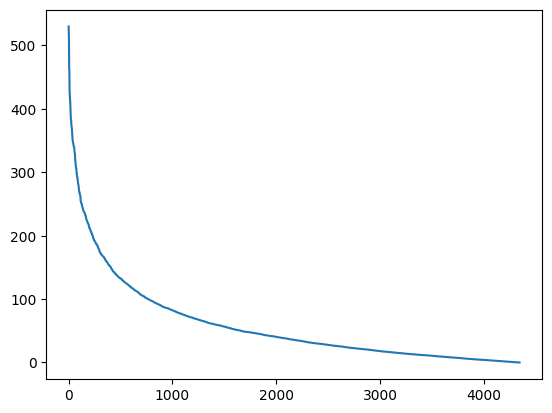

In [29]:
# Plot difference between real and predicted values
from matplotlib import pyplot as plt

# List of values y_test - prediction and sort it descending
sorted_values = sorted(abs(y_test.values - prediction), reverse=True)


plt.plot(sorted_values)
plt.show()
